# Import and setup models

In [28]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2

ssu_weights = "../../checkpoints/ema_model_student.weights.hdf5" # Semi-supervised model weights
su_weights = "../../checkpoints/model.weights.hdf5" # Supervised model weights

labelled_dir = "../../data/LungSegments/images"
unlabelled_dir = "../../data/pneumonia/train/NORMAL"

## 1. Model architecture of supervised unet

In [11]:
def build_s_unet_model():
    inputs = Input(shape=(256, 256, 3))
    init = 'he_normal' # l1(2e-4)
    reg  = l1(2e-04)

    ## Encoding path ##
    conv_1_1 = Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(inputs)
    conv_1_2 = Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_1_1)

    pool = MaxPooling2D(pool_size=(2,2))(conv_1_2)

    conv_2_1 = Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
    conv_2_2 = Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_2_1)

    pool = MaxPooling2D(pool_size=(2,2))(conv_2_2)

    conv_3_1 = Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
    conv_3_2 = Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_3_1)

    pool = MaxPooling2D(pool_size=(2,2))(conv_3_2)

    conv_4_1 = Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
    conv_4_2 = Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_4_1)

    pool = MaxPooling2D(pool_size=(2,2))(conv_4_2)

    conv_5_1 = Conv2D(1024, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
    conv_5_2 = Conv2D(1024, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_5_1)

    ## Decoding path ##
    # up1 = Conv2DTranspose(512, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_5_2)
    up1 = UpSampling2D(size=(2,2))(conv_5_2)
    up1 = Concatenate(axis=3)([conv_4_2, up1])

    upconv_1_1 = Conv2D(512, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up1)
    upconv_1_2 = Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_1_1)

    # up2 = Conv2DTranspose(256, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_1_2)
    up2 = UpSampling2D(size=(2,2))(upconv_1_2)
    up2 = Concatenate(axis=3)([conv_3_2, up2])

    upconv_2_1 = Conv2D(256, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up2)
    upconv_2_2 = Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_2_1)

    # up3 = Conv2DTranspose(128, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_2_2)
    up3 = UpSampling2D(size=(2,2))(upconv_2_2)
    up3 = Concatenate(axis=3)([conv_2_2, up3])

    upconv_3_1 = Conv2D(128, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up3)
    upconv_3_2 = Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_3_1)

    # up4 = Conv2DTranspose(64, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_3_2)
    up4 = UpSampling2D(size=(2,2))(upconv_3_2)
    up4 = Concatenate(axis=3)([conv_1_2, up4])

    upconv_4_1 = Conv2D(64, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up4)
    upconv_4_2 = Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_4_1)
    output = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same', kernel_initializer=init, kernel_regularizer=reg)(upconv_4_2)

    model = Model(inputs=inputs, outputs=output, name='UNet-Lung-Segmentation')
    return model


## 2. Model architecture of semi-supervised unet

In [12]:
def build_ss_unet_model(batchnorm=False):
        inputs = Input(shape=(256, 256, 3))
        init = 'he_uniform' # l1(2e-4)
        reg  = l1(2e-04)

        ## Encoding path ##
        conv_1_1 = Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(inputs)
        conv_1_2 = Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_1_1)
        if(batchnorm): conv_1_2 = BatchNormalization()(conv_1_2)
        conv_1_2 = Dropout(0.5)(conv_1_2)

        pool = MaxPooling2D(pool_size=(2,2))(conv_1_2)

        conv_2_1 = Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
        conv_2_2 = Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_2_1)
        if(batchnorm): conv_2_2 = BatchNormalization()(conv_2_2)
        conv_2_2 = Dropout(0.5)(conv_2_2)

        pool = MaxPooling2D(pool_size=(2,2))(conv_2_2)

        conv_3_1 = Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
        conv_3_2 = Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_3_1)
        if(batchnorm): conv_3_2 = BatchNormalization()(conv_3_2)
        conv_3_2 = Dropout(0.5)(conv_3_2)

        pool = MaxPooling2D(pool_size=(2,2))(conv_3_2)

        conv_4_1 = Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
        conv_4_2 = Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_4_1)
        if(batchnorm): conv_4_2 = BatchNormalization()(conv_4_2)
        conv_4_2 = Dropout(0.5)(conv_4_2)

        pool = MaxPooling2D(pool_size=(2,2))(conv_4_2)

        conv_5_1 = Conv2D(1024, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(pool)
        conv_5_2 = Conv2D(1024, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_5_1)
        if(batchnorm): conv_5_2 = BatchNormalization()(conv_5_2)
        conv_5_2 = Dropout(0.5)(conv_5_2)

        ## Decoding path ##
        # up1 = Conv2DTranspose(512, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(conv_5_2)
        up1 = UpSampling2D(size=(2,2))(conv_5_2)
        up1 = Concatenate(axis=3)([conv_4_2, up1])

        upconv_1_1 = Conv2D(512, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up1)
        upconv_1_2 = Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_1_1)
        if(batchnorm): upconv_1_2 = BatchNormalization()(upconv_1_2)
        upconv_1_2 = Dropout(0.5)(upconv_1_2)

        # up2 = Conv2DTranspose(256, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_1_2)
        up2 = UpSampling2D(size=(2,2))(upconv_1_2)
        up2 = Concatenate(axis=3)([conv_3_2, up2])

        upconv_2_1 = Conv2D(256, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up2)
        upconv_2_2 = Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_2_1)
        if(batchnorm): upconv_2_2 = BatchNormalization()(upconv_2_2)
        upconv_2_2 = Dropout(0.5)(upconv_2_2)

        # up3 = Conv2DTranspose(128, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_2_2)
        up3 = UpSampling2D(size=(2,2))(upconv_2_2)
        up3 = Concatenate(axis=3)([conv_2_2, up3])

        upconv_3_1 = Conv2D(128, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up3)
        upconv_3_2 = Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_3_1)
        if(batchnorm): upconv_3_2 = BatchNormalization()(upconv_3_2)
        upconv_3_2 = Dropout(0.5)(upconv_3_2)

        # up4 = Conv2DTranspose(64, kernel_size=2, strides=(2,2), padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_3_2)
        up4 = UpSampling2D(size=(2,2))(upconv_3_2)
        up4 = Concatenate(axis=3)([conv_1_2, up4])

        upconv_4_1 = Conv2D(64, kernel_size=2, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(up4)
        upconv_4_2 = Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer=init, kernel_regularizer=reg)(upconv_4_1)
        if(batchnorm): upconv_4_2 = BatchNormalization()(upconv_4_2)
        upconv_4_2 = Dropout(0.5)(upconv_4_2)
        logits = Conv2D(1, kernel_size=3, activation=None, padding='same', kernel_initializer=init, kernel_regularizer=reg)(upconv_4_2)
        output = Activation('sigmoid')(logits)

        model = Model(inputs=inputs, outputs=[output, logits], name='UNet-Lung-Segmentation')
        return model


# Build models

In [13]:
su_model = build_s_unet_model()
ssu_model = build_ss_unet_model(batchnorm=True)

su_model.load_weights(su_weights)
ssu_model.load_weights(ssu_weights)

# Load testing images from both labelled and unlabelled datasets

In [15]:
labelled_img_files = glob.glob(f'{labelled_dir}/*.png')
unlabelled_img_files = glob.glob(f'{unlabelled_dir}/*.jpeg')

print(f'{len(labelled_img_files)} labelled image files')
print(f'{len(unlabelled_img_files)} unlabelled image files')

800 labelled image files
1341 unlabelled image files


In [25]:
labelled_img_files = np.random.choice(labelled_img_files, size=8)
unlabelled_img_files = np.random.choice(unlabelled_img_files, size=8)

labelled_images = []
unlabelled_images = []

def preprocess_img(img):
    img = cv2.resize(img, (256, 256))
    
    mu = np.mean(img)
    std = np.std(img)
    
    img = (img - mu)/std
    
    if(len(img.shape) == 2):
        img_ = np.zeros((256, 256, 3))
        img_[:, :, 0] = img
        img_[:, :, 1] = img
        img_[:, :, 2] = img

        return img_
    
    return img

for i in range(len(labelled_img_files)):
    labelled_img = cv2.imread(labelled_img_files[i], cv2.COLOR_BGR2RGB)
    unlabelled_img = cv2.imread(unlabelled_img_files[i], cv2.COLOR_BGR2RGB)
    
    labelled_img = preprocess_img(labelled_img)
    unlabelled_img = preprocess_img(unlabelled_img)
    
    labelled_images.append(labelled_img)
    unlabelled_images.append(unlabelled_img)

# Predictions using fully supervised model 

## 1. Prediction on labelled data

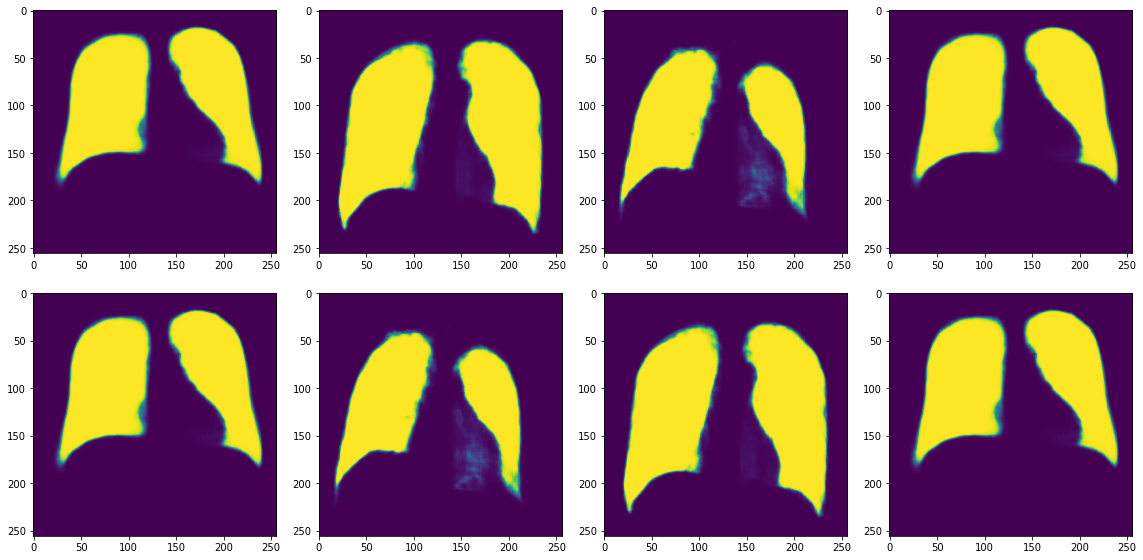

In [34]:
predictions = su_model.predict(np.array(labelled_images))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(len(predictions)):
    row = i // 4
    col = i % 4
    
    ax[row][col].imshow(predictions[i])
    
plt.tight_layout()
plt.show()

## 2. Prediction on unlabelled data

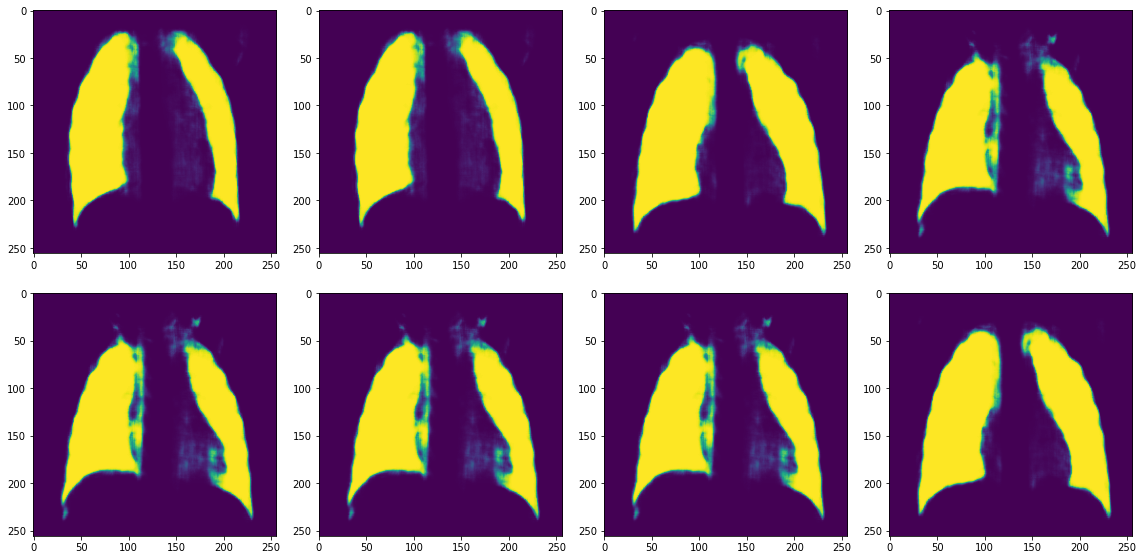

In [35]:
predictions = su_model.predict(np.array(unlabelled_images))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(len(predictions)):
    row = i // 4
    col = i % 4
    
    ax[row][col].imshow(predictions[i])
    
plt.tight_layout()
plt.show()

# Predictions using semi-supervised model

## 1. Predictions on labelled data

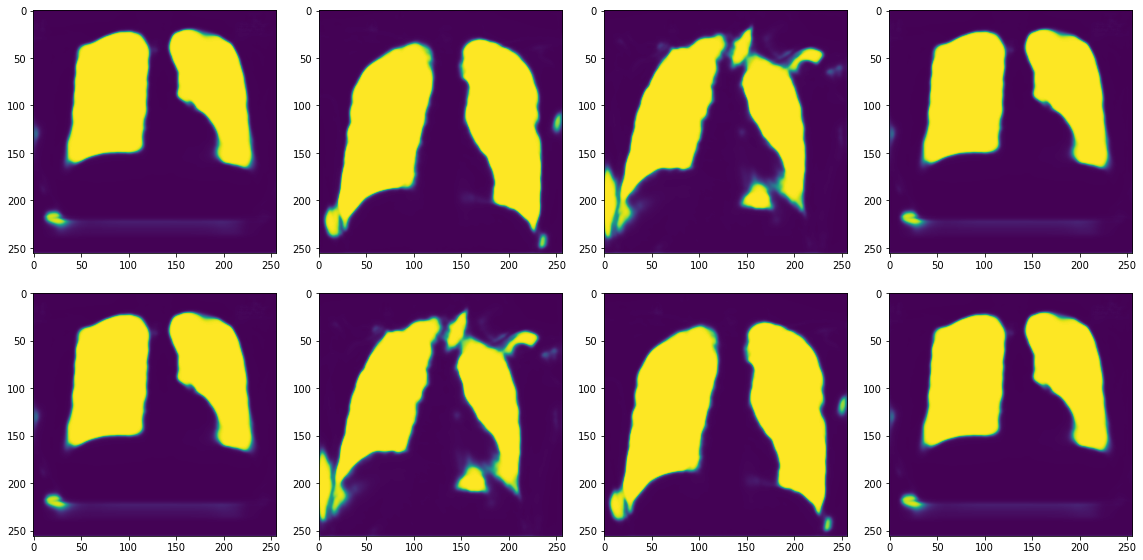

In [37]:
predictions, logits = ssu_model.predict(np.array(labelled_images))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(len(predictions)):
    row = i // 4
    col = i % 4
    
    ax[row][col].imshow(predictions[i])
    
plt.tight_layout()
plt.show()

## 2. Predictions on unlabelled data

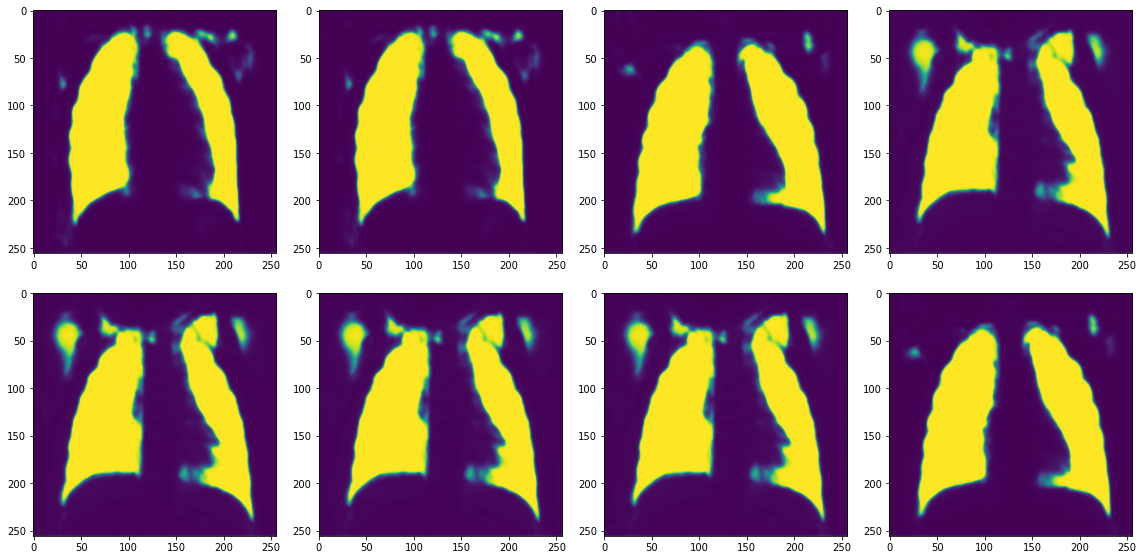

In [40]:
predictions, logits = ssu_model.predict(np.array(unlabelled_images))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(len(predictions)):
    row = i // 4
    col = i % 4
    
    ax[row][col].imshow(predictions[i])
    
plt.tight_layout()
plt.show()